In [0]:
import zipfile
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive, files
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation,Flatten
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from keras.utils import np_utils
%matplotlib inline

drive.mount('/content/gdrive',force_remount=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


# Unzipping the file with the images

In [0]:
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/Big Data/Projet/celeba-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/img/')

# Création de la base de données

In [0]:
samp = pickle.load(open('/content/gdrive/My Drive/Big Data/Projet/Listes sample/No_Beard.pkl', 'rb'))
landmarks = pd.read_csv('/content/img/list_landmarks_align_celeba.csv')

In [0]:
sub_landmarks = landmarks[['image_id','leftmouth_x','leftmouth_y','rightmouth_x','rightmouth_y']]
coord_faces = sub_landmarks.loc[sub_landmarks[sub_landmarks['image_id'].isin(samp) == True].index]
coord_faces = coord_faces.set_index('image_id')
coord_faces.head()

,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,
000023.jpg,71,153,105,151
000033.jpg,72,152,105,152
000052.jpg,72,153,105,153
000053.jpg,72,153,103,152
000056.jpg,74,152,103,152


Show a random image

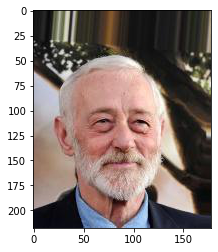

In [0]:
random_face = np.random.randint(len(coord_faces))
image = Image.open('/content/img/img_align_celeba/img_align_celeba/' + coord_faces.index[random_face])
plt.imshow(image)

Show the important part of the image

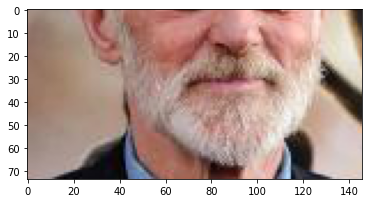

In [0]:
plt.imshow(image.crop((0, min(coord_faces.leftmouth_y.loc[coord_faces.index[random_face]],
                              coord_faces.rightmouth_y.loc[coord_faces.index[random_face]])-30, 
                       max(coord_faces.rightmouth_x + 30), max(landmarks.nose_y+40)))) 

In [0]:
path = '/content/img/img_align_celeba/img_align_celeba/'
target = []
data_lower = np.zeros((len(samp), 64, 64, 3)) #dimension of the images
count = 0
for file in os.listdir(path) :
  if file in samp :
    temp = file
    image = Image.open(path + file)
    
    separation = min(coord_faces.leftmouth_y.loc[file],
                    coord_faces.rightmouth_y.loc[file])-30
    image = image.crop((0, separation, max(coord_faces.rightmouth_x + 30), max(landmarks.nose_y+40)))
    image = image.resize((64, 64))
    image = np.array(image)
    data_lower[count] = image
    target.append(file)
    count += 1

In [0]:
all_attributes = pd.read_csv('/content/img/list_attr_celeba.csv')
No_Beard = all_attributes[['image_id','No_Beard']]
No_Beard = No_Beard.loc[No_Beard[No_Beard['image_id'].isin(target) == True].index]
No_Beard = No_Beard.set_index('image_id')
No_Beard = No_Beard.loc[target]
No_Beard.head()

,No_Beard
image_id,
145452.jpg,-1
034270.jpg,-1
053093.jpg,-1
092663.jpg,1
201843.jpg,-1


# Creation of the train and test sets

In [0]:
y = np.array(No_Beard.No_Beard)
y[y==-1] = 0

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_lower, y, 
                                                    test_size = 0.2)

In [0]:
print(X_train.shape, y_train.shape)

(16000, 64, 64, 3) (16000,)


In [0]:
y_train.shape

(16000,)

# Creation of the NN

In [0]:
conv_net = Sequential()

# # convolution layer 1
conv_net.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (64, 64, 3)))
conv_net.add(MaxPooling2D(pool_size = (2, 2)))

# print(conv_net.output.shape)

# convolution layer 2
conv_net.add(Conv2D(128, (3, 3), activation = 'relu'))
conv_net.add(MaxPooling2D(pool_size = (2, 2)))

# convolution layer 3
conv_net.add(Conv2D(256, (3, 3), activation = 'relu'))
conv_net.add(MaxPooling2D(pool_size = (2, 2)))

# convolution layer 4
conv_net.add(Conv2D(512, (3, 3), activation = 'relu'))
conv_net.add(MaxPooling2D(pool_size = (2, 2)))


conv_net.add(Flatten())
conv_net.add(Dense(512, activation = 'relu'))
conv_net.add(Dropout(0.2))
conv_net.add(Dense(256, activation = 'relu'))
conv_net.add(Dense(1, activation = 'sigmoid'))

conv_net.compile(loss = 'binary_crossentropy', optimizer = 'adam', 
                 metrics = ['accuracy'])

## callbacks to save the best model

In [0]:
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2,
                              patience = 1, min_lr = 0.001)

# Path where we will save our model
filepath = "/content/gdrive/My Drive/Big Data/models no_beard/No_beard.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy',
                             verbose = 1, save_best_only = True,
                             mode = 'max')
callbacks = [checkpoint, reduce_lr]

In [0]:
history = conv_net.fit(X_train, y_train, batch_size = 128, epochs = 20,
                       validation_data = (X_test, y_test), callbacks = callbacks)

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.5362
Epoch 00001: val_accuracy improved from -inf to 0.53450, saving model to /content/gdrive/My Drive/Big Data/models no_beard/No_beard.hdf5
125/125 [==============================] - 60s 478ms/step - loss: 1.0396 - accuracy: 0.5362 - val_loss: 0.6932 - val_accuracy: 0.5345 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.6043
Epoch 00002: val_accuracy improved from 0.53450 to 0.66575, saving model to /content/gdrive/My Drive/Big Data/models no_beard/No_beard.hdf5
125/125 [==============================] - 59s 473ms/step - loss: 0.6581 - accuracy: 0.6043 - val_loss: 0.6159 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.7344
Epoch 00003: val_accuracy improved from 0.66575 to 0.78150, saving model to /content/gdrive/My Drive/Big Data/models no_beard/No_beard.hdf5
1

## Load the saved model

In [0]:
no_beard_model = load_model( "/content/gdrive/My Drive/Big Data/models no_beard/No_beard.hdf5")

In [0]:
accuracy = no_beard_model.evaluate(X_test, y_test, verbose = 0)[1]
print(accuracy)

0.8272500038146973
